# OpenSecrets: Personal Finance Data
Data source: https://www.opensecrets.org/bulk-data/downloads  
Documentations: https://www.opensecrets.org/resources/datadictionary/Data%20Dictionary%20pfd_trans.htm

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
with open("../data/pfd/PFDtrans.txt") as f: 
    for _ in range(2):
        print(f.readline())

|A170015889|,|s|,|N00009888|,|17|,|Y|,|S|,|Tortoise MLP & Pipeline Instl|,|Tortoise MLP & Pipeline Fund|,||,||,||,||,||,||,||,||,|x|,| |,| |,,|09/29/2017|,|C |,,| |,|--|,|d|

|A170015888|,|s|,|N00009888|,|17|,|Y|,|S|,|Vanguard Dividend Appreciation ETF|,|Vanguard Dividend Appreciation ETF|,||,||,||,||,||,||,||,||,|x|,| |,| |,,|07/19/2017|,|C |,,| |,|--|,|d|



In [3]:
pfd_colnames=['ID', 'Chamber', 'CID', 'CalendarYear', 'ReportType', 'Asset4SJD', 'Asset4Transacted', 'Orgname', 'Ultorg', 'RealCode', 'Source', 'Asset4Descrip', 'Orgname2', 'Ultorg2', 'RealCode2', 'Source2', 'Asset4Purchased', 'Asset4Sold', 'Asset4Exchanged', 'Asset4Date', 'Asset4DateText', 'Asset4TransAmt', 'Asset4ExactAmt', 'CofD', 'TransNotes', 'Dupe'] 
pfd = pd.read_csv("../data/pfd/PFDtrans_test.txt", encoding="latin-1", sep="\t", names=pfd_colnames, header=None)
pfd

C:\Users\Yiyan\AppData\Local\Programs\Python\Python38\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (3,8,11,13,22,24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,ID,Chamber,CID,CalendarYear,ReportType,Asset4SJD,Asset4Transacted,Orgname,Ultorg,RealCode,...,Asset4Purchased,Asset4Sold,Asset4Exchanged,Asset4Date,Asset4DateText,Asset4TransAmt,Asset4ExactAmt,CofD,TransNotes,Dupe
0,A170015889,s,N00009888,17,Y,S,Tortoise MLP & Pipeline Instl,Tortoise MLP & Pipeline Fund,NaN,NaN,...,x,,,NaN,09/29/2017,C,NaN,,--,d
1,A170015888,s,N00009888,17,Y,S,Vanguard Dividend Appreciation ETF,Vanguard Dividend Appreciation ETF,NaN,NaN,...,x,,,NaN,07/19/2017,C,NaN,,--,d
2,A170015887,s,N00009888,17,Y,S,UBS ETRACS Alerian MLP Infras ETN,UBS ETRACS Alerian MLP Infras ETN,NaN,NaN,...,x,,,NaN,07/19/2017,C,NaN,,--,d
3,A170015886,s,N00009888,17,Y,S,Tortoise MLP & Pipeline Instl,Tortoise MLP & Pipeline Fund,NaN,NaN,...,x,,,NaN,07/17/2017,C,NaN,,--,d
4,A170015885,s,N00009888,17,Y,S,DTC US Active Equity Common Trust Fund,DTC US Active Equity Common Trust Fund,NaN,NaN,...,x,,,NaN,07/07/2017,E,NaN,,--,d
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377663,C160015720,s,N00030245,16,A,S,Oakmark Equity And Income Investor,Oakmark Equity & Income Fund,NaN,NaN,...,,x,,NaN,10/31/2016,B,NaN,,Sale (Full),d
377664,C160015719,s,N00030245,16,A,S,Oakmark Equity And Income Investor,Oakmark Equity & Income Fund,NaN,NaN,...,,x,,NaN,03/28/2016,B,NaN,,Sale (Partial),d
377665,C160015718,s,N00030245,16,A,S,First Eagle Global I,First Eagle Global Fund,NaN,NaN,...,,x,,NaN,10/31/2016,B,NaN,,Sale (Partial),d
377666,C160015717,s,N00030245,16,A,S,First Eagle Global I,First Eagle Global Fund,NaN,NaN,...,,x,,NaN,03/28/2016,B,NaN,,Sale (Partial),d


In [4]:
def process_date_text(text):
    if type(text) == float:
        return np.nan
    else:
        try: 
            return datetime.strptime(text, '%m/%d/%Y')
        except: 
            return np.nan
v_process_date_text = np.vectorize(process_date_text)

In [5]:
datetime_lst = v_process_date_text(pfd["Asset4DateText"])
datetime_lst

array([datetime.datetime(2017, 9, 29, 0, 0),
       datetime.datetime(2017, 7, 19, 0, 0),
       datetime.datetime(2017, 7, 19, 0, 0), ...,
       datetime.datetime(2016, 10, 31, 0, 0),
       datetime.datetime(2016, 3, 28, 0, 0),
       datetime.datetime(2016, 10, 31, 0, 0)], dtype=object)

In [6]:
len(datetime_lst)

377668

In [7]:
max(datetime_lst[~pd.isnull(datetime_lst)]) # obvious data entry error

datetime.datetime(2107, 4, 12, 0, 0)

In [8]:
min(datetime_lst[~pd.isnull(datetime_lst)])

datetime.datetime(1931, 6, 1, 0, 0)

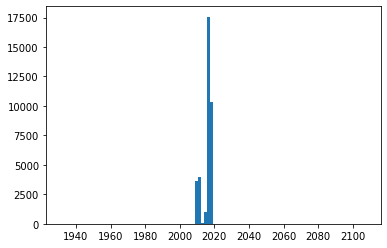

In [9]:
plt.hist(datetime_lst[~pd.isnull(datetime_lst)], bins=100);

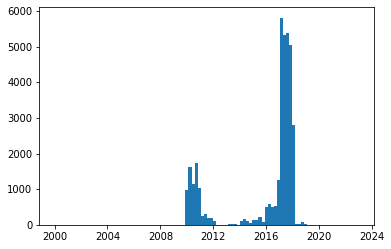

In [10]:
plt.hist(datetime_lst[~pd.isnull(datetime_lst)], range=[datetime(2000, 1, 1, 0, 0), datetime(2022, 12, 31, 0, 0)], bins=100);

### Debug

In [11]:
datetime.strptime(pfd["Asset4DateText"][0], '%m/%d/%Y')

datetime.datetime(2017, 9, 29, 0, 0)

In [12]:
for i in np.arange(len(pfd)):
    if type(pfd["Asset4DateText"][i]) == float:
        print(i, pfd["Asset4DateText"][i])
    if i > 200:
        break;

62 nan
63 nan
64 nan
65 nan
66 nan
67 nan
68 nan
69 nan
70 nan
100 nan
106 nan
107 nan
108 nan
109 nan
110 nan
111 nan
180 nan
187 nan
188 nan
189 nan
190 nan
191 nan
192 nan
193 nan
194 nan
195 nan
196 nan
197 nan
198 nan
199 nan


In [13]:
pfd.iloc[100]

ID                                                         A180015548
Chamber                                                             s
CID                                                         N00001955
CalendarYear                                                       18
ReportType                                                          Y
Asset4SJD                                                           J
Asset4Transacted     Meyer M. Cardin Trust - Montgomery Co., Md. Bond
Orgname                                          Meyer M Cardin Trust
Ultorg                                                            NaN
RealCode                                                          NaN
Source                                                            NaN
Asset4Descrip                                                     NaN
Orgname2                                     Montgomery CN MD Go Bond
Ultorg2                                                           NaN
RealCode2           

In [14]:
pfd["Asset4Date"] = list(map(lambda x: datetime.strptime(x, '%m/%d/%Y'), pfd["Asset4DateText"]))

TypeError: strptime() argument 1 must be str, not float

In [ ]:
list(map(lambda x: datetime.strptime(x, '%m/%d/%Y'), pfd["Asset4DateText"]))